In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
# plt.style.use('seaborn-whitegrid')
plt.style.use('fivethirtyeight')
import pandas as pd
import numpy as np

adult = pd.read_csv("adult_with_pii.csv")
def laplace_mech(v, sensitivity, epsilon):
    return v + np.random.laplace(loc=0, scale=sensitivity / epsilon)
def pct_error(orig, priv):
    return np.abs(orig - priv)/orig * 100.0

稀疏向量技术

稀疏向量技术（Sparse Vector Technique，SVT）
实际应用已证明稀疏向量技术可以非常有效地节省隐私消耗量。稀疏向量技术适用于在数据集上执行敏感度为1的问询流。此技术只发布问询流中第一个通过测试的问询索引号，而不发布其他任何信息。稀疏向量技术的优势在于，无论总共收到了多少问询，此机制消耗的总隐私消耗量都是固定的。

高于阈值算法

In [2]:
import random

# 满足ε-差分隐私
def above_threshold(queries, df, T, epsilon):
    T_hat = T + np.random.laplace(loc=0, scale = 2/epsilon)   
    for idx, q in enumerate(queries):
        nu_i = np.random.laplace(loc=0, scale = 4/epsilon)
        if q(df) + nu_i >= T_hat:
            return idx   
    return random.randint(0,len(queries)-1)

def above_threshold_fail_signal(queries, df, T, epsilon):
    T_hat = T + np.random.laplace(loc=0, scale = 2/epsilon)
    
    for idx, q in enumerate(queries):
        nu_i = np.random.laplace(loc=0, scale = 4/epsilon)
        if q(df) + nu_i >= T_hat:
            return idx
    # 返回一个无效的问询索引号    
    return None 

In [3]:
# 满足|queries|*ε-差分隐私
def naive_above_threshold(queries, df, T, epsilon):
    for idx, q in enumerate(queries):
        nu_i = np.random.laplace(loc=0, scale = 1/epsilon)
        if q(df) + nu_i >= T:
            return idx
    return None

应用稀疏向量技术

当我们想执行很多不同的问询，但我们只关心其中一个问询（或一小部分问询）的回复结果时，稀疏向量技术就有很大的用武之地了。实际上，之所以叫稀疏向量技术，正是因为此技术的适用场景：问询向量越稀疏（即大多数回复结果不会超过阈值），此技术作用最大。

在前面提到的场景中，我们已经有了一个完美的适用场景：选择求和问询的裁剪边界。之前，我们实现的方法类似于AboveThreshold的朴素实现：获得多个不同的裁剪边界后，分别计算噪声裁剪边界，并选择一个尽可能低的，且不会导致最终回复结果改变太大的一个裁剪边界。

我们可以通过使用稀疏向量技术获得更好的效果。考虑这样一个问询：此问询首先对数据集中每个人的年龄进行裁剪，再把裁剪结果求和：

In [4]:
def age_sum_query(df, b):
    return df['Age'].clip(lower=0, upper=b).sum()

age_sum_query(adult, 30)

913809

我们想选择一个较好的b。朴素算法是获取多个满足差分隐私的b，返回使求和结果不再增大的最小的b。

In [5]:
def naive_select_b(query, df, epsilon):
    bs = range(1, 1000, 10)
    best = 0
    threshold = 10
    epsilon_i = epsilon / len(bs)
    
    for b in bs:
        r = laplace_mech(query(df, b), b, epsilon_i)
        
        # 如果新的求和结果与旧的求和结果很接近，则停止
        if r - best <= threshold:
            return b
        # 否则，将"最佳"求和结果更新为当前求和结果
        else:
            best = r
        
    return bs[-1]

naive_select_b(age_sum_query, adult, 1)

71

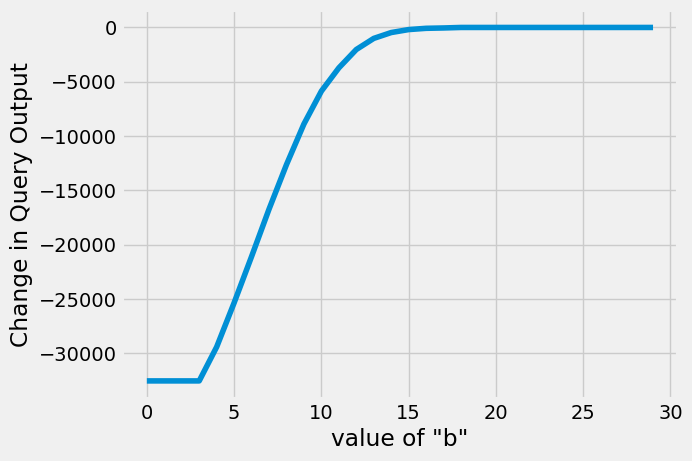

In [6]:
bs = range(1,150,5)
query_results = [age_sum_query(adult, b) - age_sum_query(adult, b + 1) for b in bs]
plt.xlabel('value of "b"')
plt.ylabel('Change in Query Output')
plt.plot(query_results);

根据这一观察结论，我们来定义一个求和差问询流，并基于稀疏向量技术，应用AboveThreshold确定最佳b的问询索引号。

In [7]:
def create_query(b):
    return lambda df: age_sum_query(df, b) - age_sum_query(df, b + 1)

bs = range(1,150,5)
queries = [create_query(b) for b in bs]
epsilon = .1

bs[above_threshold(queries, adult, 0, epsilon)]

86

请注意，备选b的列表有多长并不重要。无论此列表有多长，我们都能获得准确的结果（并消耗相同的隐私预算）。稀疏向量技术真正的强大之处在于，其消除了隐私消耗量与所执行问询数量的依赖关系。尝试改变上述b的备选范围后重新运行此机制，可以得到下图。我们可以看到，机制的输出结果不依赖于b的数量。即使备选b的列表中包含上千个元素，我们仍将得到准确的结果.

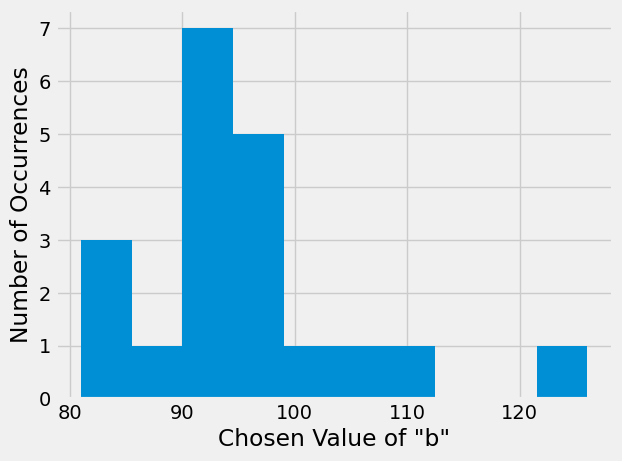

In [8]:
plt.xlabel('Chosen Value of "b"')
plt.ylabel('Number of Occurrences')
plt.hist([bs[above_threshold(queries, adult, 0, epsilon)] for i in range(20)]);

我们可以使用稀疏向量技术构建可自动计算裁剪参数的求和问询算法（也可以构建对应的均值问询算法）。

In [9]:
def auto_avg(df, epsilon):
    def create_query(b):
        return lambda df: df.clip(lower=0, upper=b).sum() - df.clip(lower=0, upper=b+1).sum()

    # 构造问询流
    bs = range(1,150000,5)
    queries = [create_query(b) for b in bs]
    
    # 使用1/3的隐私预算执行AboveThreshold，得到一个好的裁剪参数
    epsilon_svt = epsilon / 3
    final_b = bs[above_threshold(queries, df, 0, epsilon_svt)]

    # 分别使用1/3的隐私预算来获得噪声求和值与噪声计数值
    epsilon_sum = epsilon / 3
    epsilon_count = epsilon / 3
    
    noisy_sum = laplace_mech(df.clip(lower=0, upper=final_b).sum(), final_b, epsilon_sum)
    noisy_count = laplace_mech(len(df), 1, epsilon_count)
    
    return noisy_sum/noisy_count

auto_avg(adult['Age'], 1)

38.58884165702821

该算法调用了三个差分隐私机制：一次AboveThreshold，两次拉普拉斯机制，每个机制消耗三分之一的隐私预算。根据串行组合性，此算法满足eplison-差分隐私。由于我们可自由测试b更大可能的取值范围，因此我们能够对不同尺度的数据使用相同的auto_avg函数！例如，我们也可以在资本收益列上使用auto_avg函数。要知道，资本收益列的数据尺度与年龄列有很大的区别。

返回多个问询结果

In [10]:
def sparse(queries, df, c, T, epsilon):
    idxs = []
    pos = 0
    epsilon_i = epsilon / c
    
    # 如果我们执行完问询流中的所有问询，或者我们找到了c个超过阈值的问询回复，则停止
    while pos < len(queries) and len(idxs) < c:
        # 执行AboveThreshold，寻找下一个超过阈值的问询回复
        next_idx = above_threshold_fail_signal(queries[pos:], df, T, epsilon_i)
        
        # 如果AboveThreshold执行完了最后一个问询，则返回所有超过阈值的问询索引号
        if next_idx == None:
            return idxs
        
        # 否则，更新pos，使其指向问询流中剩余的问询
        pos = next_idx+pos
        # 更新idxs，添加AboveThreshold找到的问询索引号
        idxs.append(pos)
        # 移动到问询流中的下一个问询
        pos = pos + 1

    return idxs

In [11]:
epsilon = 1
sparse(queries, adult, 3, 0, epsilon)

[18, 19, 21]

应用：范围问询

范围问询（Range Query）要问的是："数据集中有多少行的值落在范围(a,b)
中？"范围问询是一种计数问询，因此其敏感度为1；我们不能对一组范围问询使用并行组合性，因为满足相应问询条件的数据行可能会有重叠。

考虑一组针对年龄列的范围即问询形式为"有多少人的年龄在a和b之间之间？"）。我们可以随机生成很多这样的问询：

In [12]:
def age_range_query(df, lower, upper):
    df1 = df[df['Age'] > lower]
    return len(df1[df1['Age'] < upper])

def create_age_range_query():
    lower = np.random.randint(30, 50)
    upper = np.random.randint(lower, 70)
    return lambda df: age_range_query(df, lower, upper)


range_queries = [create_age_range_query() for i in range(10)]
results = [q(adult) for q in range_queries]
results

[9099, 8009, 12230, 1756, 11771, 16628, 11176, 9211, 770, 5891]

这些范围问询的回复结果可能相差甚远。部分问询范围可能只会匹配上很少的数据行（甚至匹配不上任何数据行），对应的计数值很小。然而，另一部分问询范围可能会匹配上大量的数据行，对应的计数值很大。在多数情况下，我们知道小计数值的差分隐私回复结果会很不准确，得到这些问询结果的实际意义不大。我们想要做的是了解哪些问询的结果是有价值的，并仅为这些有价值的问询结果支付隐私预算。

我们可以使用稀疏向量技术实现这一点。首先，我们确定一个阈值，并得到范围问询流中回复结果超过此阈值的问询索引号。我们认为这些问询都是"有价值的"问询。随后，我们应用拉普拉斯机制得到这些有价值问询的差分隐私回复结果。这样一来，总隐私开销与超过阈值的问询数量成正比，而非与总问询数量成正比。如果我们预计只有少数问询的回复结果会超过阈值，则所需的总隐私开销会小得多。

In [13]:
def range_query_svt(queries, df, c, T, epsilon):
    # 首先，执行sparse，得到"有价值的"问询
    sparse_epsilon = epsilon / 2
    indices = sparse(queries, adult, c, T, sparse_epsilon)
    
    # 所有，为每个"有价值的"问询执行拉普拉斯机制
    laplace_epsilon = epsilon / (2*c)
    results = [laplace_mech(queries[i](df), 1, laplace_epsilon) for i in indices]
    return results

In [14]:
range_query_svt(range_queries, adult, 5, 10000, 1)

[12200.14123870815, 11773.315152822877, 16630.96534978987, 11164.84429775009]

此算法实现中，我们使用一半的隐私预算来确定高于阈值10000的前c
个问询，另一半隐私预算则用于获取这些问询的噪声回复结果。如果高于阈值的问询数量远小于总问询数量，使用此方法就可以获得更准确的回复结果。